In [10]:
%load_ext autoreload
%autoreload 2

import torch

import numpy as np
import diveslowlearnfast as dlf
import matplotlib.pyplot as plt
import tools.visualise as viz

from diveslowlearnfast.config import Config, load_config
from diveslowlearnfast.train import StatsDB
from diveslowlearnfast.models import SlowFast
from diveslowlearnfast.datasets import Diving48Dataset, Diving48ConfounderDatasetWrapper
from diveslowlearnfast.visualise.gradcam import GradCAM
from torch.utils.data import DataLoader

from diveslowlearnfast.train.stats import get_value, get_tuple, get_column, get_dict, get_df

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
chk = torch.load('best.pth', map_location='cpu', weights_only=False)
chk['epoch']

190

In [4]:
cfg = load_config('config.json')
cfg.DATA.DATASET_PATH = '/Users/youritomassen/Projects/xai/data/Diving48/'
cfg.DATA.TEST_CROP_SIZE = 224
cfg.TRAIN.BATCH_SIZE = 1
cfg.DATA_LOADER.NUM_WORKERS = 1
cfg.DATA_LOADER.PIN_MEMORY = False
cfg.DATA_LOADER.USE_DECORD = False
model = dlf.model_from_checkpoint(cfg, 'checkpoint.pth')
gc = GradCAM(model,
             target_layers=['s5/pathway0_res2', 's5/pathway0_res2'],
             data_mean=cfg.DATA.MEAN,
             data_std=cfg.DATA.STD,
             colormap='jet')
model.eval()

SlowFast(
  (s1): VideoModelStem(
    (pathway0_stem): ResNetBasicStem(
      (conv): Conv3d(3, 64, kernel_size=(1, 7, 7), stride=(1, 2, 2), padding=(0, 3, 3), bias=False)
      (bn): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (pool_layer): MaxPool3d(kernel_size=[1, 3, 3], stride=[1, 2, 2], padding=[0, 1, 1], dilation=1, ceil_mode=False)
    )
    (pathway1_stem): ResNetBasicStem(
      (conv): Conv3d(3, 8, kernel_size=(5, 7, 7), stride=(1, 2, 2), padding=(2, 3, 3), bias=False)
      (bn): BatchNorm3d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (pool_layer): MaxPool3d(kernel_size=[1, 3, 3], stride=[1, 2, 2], padding=[0, 1, 1], dilation=1, ceil_mode=False)
    )
  )
  (s1_fuse): FuseFastToSlow(
    (conv_f2s): Conv3d(8, 16, kernel_size=(7, 1, 1), stride=(4, 1, 1), padding=(3, 0, 0), bias=False)
    (bn): BatchNorm3d(16, eps=1e-05, momentum=0.1, affine=True, track_running_sta

In [5]:
stats = StatsDB('stats.db')
run_id = stats.execute_query('SELECT DISTINCT(run_id) FROM stats', extractor=get_value)

run_id

'/home/s2871513/Projects/diveslowlearnfast/results/run33'

In [7]:
include_labels = stats.execute_query('SELECT DISTINCT(gt) FROM stats WHERE split = "train"', extractor=get_tuple)
include_labels

(45, 18, 25)

In [13]:
diving48 = Diving48Dataset(
    cfg.DATA.DATASET_PATH,
    cfg.DATA.NUM_FRAMES,
    dataset_type='train',
    transform_fn=dlf.get_test_transform(cfg),  # use test_transform instead
    multi_thread_decode=cfg.DATA.MULTI_THREAD_DECODE,
    use_sampling_ratio=cfg.DATA.USE_SAMPLING_RATIO,
    include_labels=include_labels,
)

confounder_diving48 = Diving48ConfounderDatasetWrapper(
    diving48,
    cfg
)

loader = DataLoader(
    diving48,
    batch_size=cfg.TRAIN.BATCH_SIZE,
    pin_memory=cfg.DATA_LOADER.PIN_MEMORY,
    num_workers=cfg.DATA_LOADER.NUM_WORKERS,
    shuffle=True,
)

confounder_loader = DataLoader(
    confounder_diving48,
    batch_size=cfg.TRAIN.BATCH_SIZE,
    pin_memory=cfg.DATA_LOADER.PIN_MEMORY,
    num_workers=cfg.DATA_LOADER.NUM_WORKERS,
    shuffle=True,
)

In [113]:
xb, yb = dlf.get_sample(confounder_loader)

In [114]:
x = xb.squeeze(0)
y = yb.squeeze(0)

x.shape, y, diving48.get_label(y.item())

(torch.Size([3, 8, 224, 224]),
 tensor(18),
 ['Forward', '15som', '2Twis', 'FREE'])

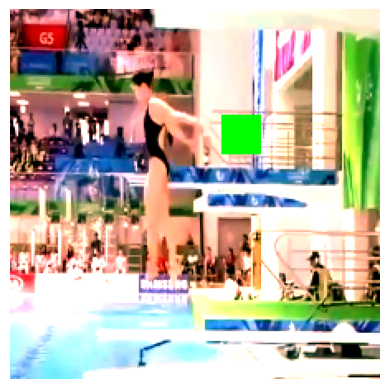

In [115]:
dlf.frameshow(x)

In [116]:
inputs = dlf.to_slowfast_inputs(xb, cfg.SLOWFAST.ALPHA)
probs = model(inputs)
torch.topk(probs, 5).indices.numpy()

array([[18, 25, 45, 46, 30]])

In [117]:
print(f'model prediction: {probs.argmax(dim=1).item()}')
print(f'actual : {y.item()}')

model prediction: 18
actual : 18


In [118]:
localisation_maps, logits = gc(inputs)

In [119]:
heatmaps = dlf.create_heatmaps(inputs,
                               localisation_maps,
                               cfg.DATA.MEAN,
                               cfg.DATA.STD,
                               colormap='jet')
slow_map = heatmaps[0][0]
fast_map = heatmaps[1][0]

slow_map.shape, fast_map.shape

(torch.Size([3, 2, 224, 224]), torch.Size([3, 8, 224, 224]))

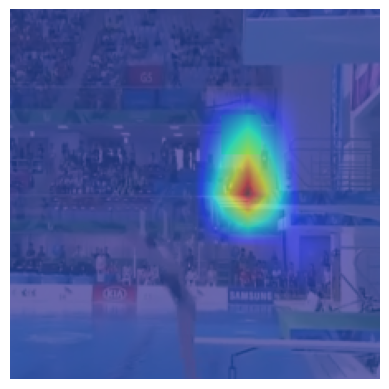

In [120]:
dlf.frameshow(slow_map, frame_idx=1)

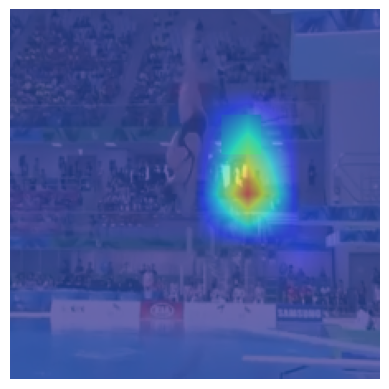

In [121]:
dlf.frameshow(fast_map, frame_idx=5)

In [103]:
from PIL import Image

def create_gif(frames, save_path):
    if type(frames) == torch.Tensor:
        frames = frames.permute(1, 2, 3, 0).detach().cpu().numpy()
        frames = np.uint8(frames * 255)

    images = [Image.fromarray(frame) for frame in frames]
    images[0].save(save_path, save_all=True, append_images=images[1:], duration=240, loop=0)



In [122]:
save_path = f"{'_'.join(diving48.get_label(y.item()))}_fast_confounder_heatmap.gif"
save_path

'Forward_15som_2Twis_FREE_fast_confounder_heatmap.gif'

In [123]:
fast_map.shape

torch.Size([3, 8, 224, 224])

In [124]:
create_gif(fast_map, save_path)

In [125]:
save_path = f"{'_'.join(diving48.get_label(y.item()))}.gif"
save_path

'Forward_15som_2Twis_FREE.gif'

In [126]:
x_denorm = dlf.tensor_denorm(x, cfg.DATA.MEAN, cfg.DATA.STD)
x_denorm = np.uint8(dlf.tensor_min_max_norm(x_denorm) * 255)
create_gif(x_denorm, save_path)

In [128]:
xb, yb = dlf.get_sample(loader)

In [130]:
x = xb.squeeze(0)
y = yb.squeeze(0)

x.shape, y, diving48.get_label(y.item())

(torch.Size([3, 8, 224, 224]),
 tensor(45),
 ['Reverse', '35som', 'NoTwis', 'TUCK'])

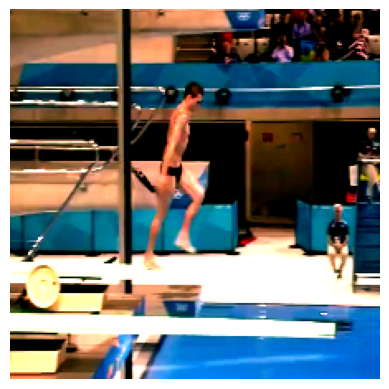

In [131]:
dlf.frameshow(x)

In [132]:
inputs = dlf.to_slowfast_inputs(xb, cfg.SLOWFAST.ALPHA)
probs = model(inputs)
torch.topk(probs, 5).indices.numpy()

array([[25, 45, 18, 22, 23]])

In [133]:
print(f'model prediction: {probs.argmax(dim=1).item()}')
print(f'actual : {y.item()}')

model prediction: 25
actual : 45


In [135]:
localisation_maps, _ = gc(inputs)
heatmaps = dlf.create_heatmaps(inputs,
                               localisation_maps,
                               cfg.DATA.MEAN,
                               cfg.DATA.STD,
                               colormap='jet')
slow_map = heatmaps[0][0]
fast_map = heatmaps[1][0]

slow_map.shape, fast_map.shape

(torch.Size([3, 2, 224, 224]), torch.Size([3, 8, 224, 224]))

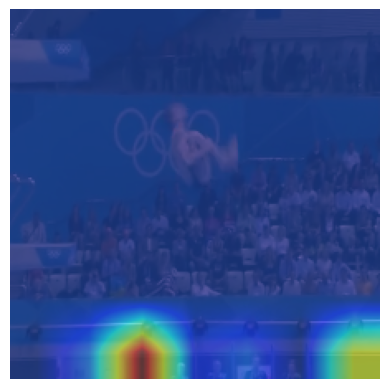

In [136]:
dlf.frameshow(slow_map, frame_idx=1)

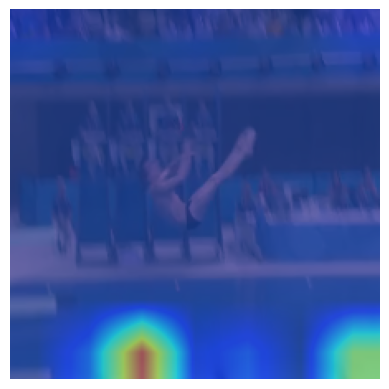

In [137]:
dlf.frameshow(fast_map, frame_idx=5)

In [140]:
save_path = f"{'_'.join(diving48.get_label(y.item()))}_fast_heatmap.gif"
save_path

'Reverse_35som_NoTwis_TUCK_fast_heatmap.gif'

In [141]:
create_gif(fast_map, save_path)

In [151]:
stats.execute_query('SELECT DISTINCT(video_id) FROM stats WHERE epoch > 185 AND split = "train" AND run_id = ?', run_id, extractor=get_column(0))

['Bb0ZiYVNtDs_00106',
 'Bb0ZiYVNtDs_00111',
 '_tigfCJFLZg_00415',
 'zbAC7t15q3k_00121',
 '_tigfCJFLZg_00322',
 'cYkUl8MrXgA_00392',
 'xbQCwTHcGN8_00195',
 'V5parOfpuEQ_00141',
 'cYkUl8MrXgA_00338',
 'V5parOfpuEQ_00145',
 'V5parOfpuEQ_00213',
 '5V-dKBtmKLI_00041',
 '_tigfCJFLZg_00298',
 'cYkUl8MrXgA_00183',
 '_tigfCJFLZg_00274',
 'V5parOfpuEQ_00083',
 'V5parOfpuEQ_00225',
 'fohMq9tOn6E_00062',
 '2x00lRzlTVQ_00094',
 'V5parOfpuEQ_00252',
 'zbAC7t15q3k_00118',
 '5V-dKBtmKLI_00097',
 'V5parOfpuEQ_00230',
 'nOlRwoxsDJ0_00853',
 'zYHstCxnAPA_00356',
 'Z_uFnDg-a4I_00104',
 'zbAC7t15q3k_00116',
 'nOlRwoxsDJ0_00411',
 'Y7QZcr24ye0_00413',
 'D8YKHC5hmUs_00188',
 'zbAC7t15q3k_00080',
 '5V-dKBtmKLI_00064',
 'sk8TafuB3lU_00603',
 'Z_uFnDg-a4I_00053',
 'D8YKHC5hmUs_00243',
 'xbQCwTHcGN8_00184',
 'S9aCrmtAV8o_00087',
 'l6ZoMjD1UtA_00026',
 'Y4ARBzok9aU_00087',
 'vlfy4cny75s_00103',
 'TeboS8s_00w_00174',
 'Z_uFnDg-a4I_00115',
 'nOlRwoxsDJ0_00749',
 '5V-dKBtmKLI_00060',
 'Y7QZcr24ye0_00963',
 'l6ZoMjD1